In [1]:
import py4DSTEM
from os.path import splitext
import numpy as np
print('py4dstem package located at C:\\Users\Sergi Plana Ruiz\AppData\Roaming\Python\Python310\site-packages\py4DSTEM')
py4DSTEM.__version__

In [2]:
filenameData = '4DSTEM_Area5_400CamLen_76x50pix_PED0p7_10nmStep_binned_shifted_quartz'
filepath_data = filenameData+'.dm4'
data4D = py4DSTEM.import_file(filepath_data)

In [3]:
# Calculate mean diffraction pattern:
dp_mean = data4D.get_dp_mean()

# Plot mean diffraction pattern:
py4DSTEM.visualize.show(
    dp_mean,
    vmin = 0, 
    vmax = 1,
    cmap='turbo',
)

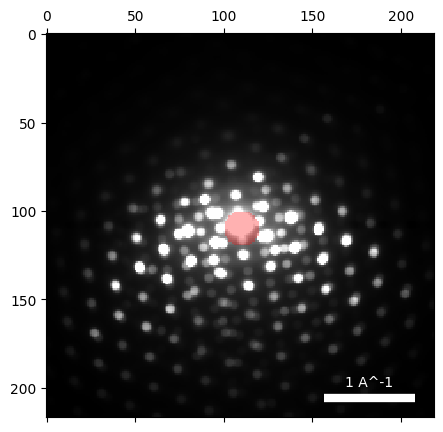

100%|███████████████████████████████████████████████████████████████████████████| 7134/7134 [00:00<00:00, 14075.24it/s]


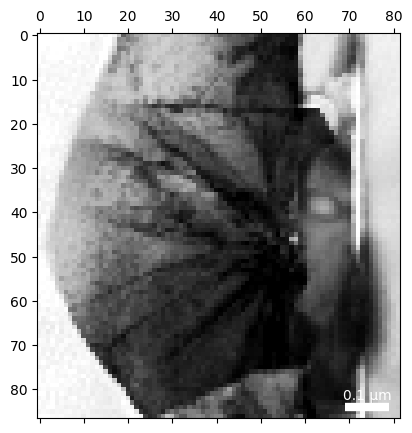

In [6]:
# BF Imaging
center = (110,110)
radius = 10
# overlay selected detector position over mean dp
data4D.position_detector(
    mode = 'circle',
    geometry = (
        center,
        radius
    )
)
data4D.get_virtual_image(
    mode = 'circle',
    geometry = (center,radius),
    name = 'bright_field',       # the output will be stored in `datacube`'s tree with this name
)
# show
py4DSTEM.visualize.show( data4D.tree('bright_field') )

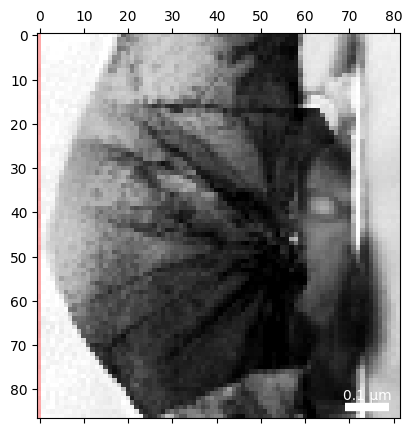

In [8]:
# Select vacuum region or only primary beam patern to generate a probe template

import numpy as np
mask = np.zeros(data4D.Rshape,dtype=bool)
mask[:,0:1] = 1

py4DSTEM.visualize.show(
    data4D.tree('bright_field'),
    mask = ~mask,
    mask_alpha = 0.667,
    mask_color = 'r'
)

100%|██████████████████████████████████████████████████████████████████████████████████| 86/86 [00:01<00:00, 52.15it/s]


Warning, vmin not provided, setting minimum intensity = -1.6827018611521482e-30
Warning, vmax not provided, setting maximum intensity = 3305068.750000001


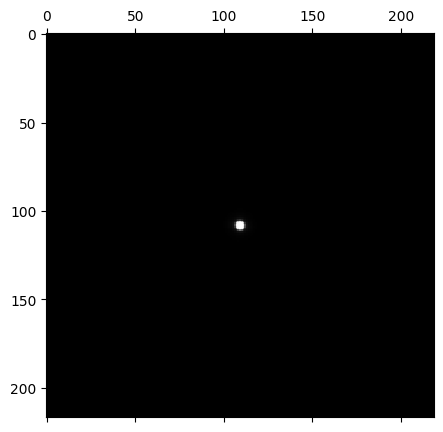

In [9]:
# Generate the probe

probe = data4D.get_vacuum_probe( ROI=mask, opening=1 )

py4DSTEM.visualize.show(probe.probe, scaling='none', intensity_range='absolute')

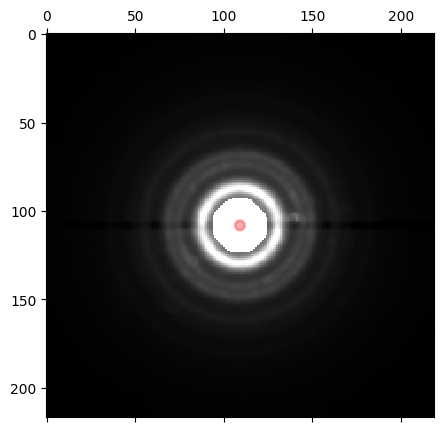

2.717116668297474
108.11463530470184
109.06499882443745


In [10]:
# Find the center and semiangle

alpha_pr,qx0_pr,qy0_pr = data4D.get_probe_size(probe.probe, thresh_lower=0.01, thresh_upper=0.99, N=100)

py4DSTEM.visualize.show(
    probe.probe, 
    scaling='none',
#     intensity_range='absolute',
#     vmin=0,vmax=7.8e3,
    circle = {
      'center':(qx0_pr,qy0_pr),
      'R': alpha_pr,
      'alpha':0.3,
      'fill':True
    }
)
print(alpha_pr)
print(qx0_pr)
print(qy0_pr)

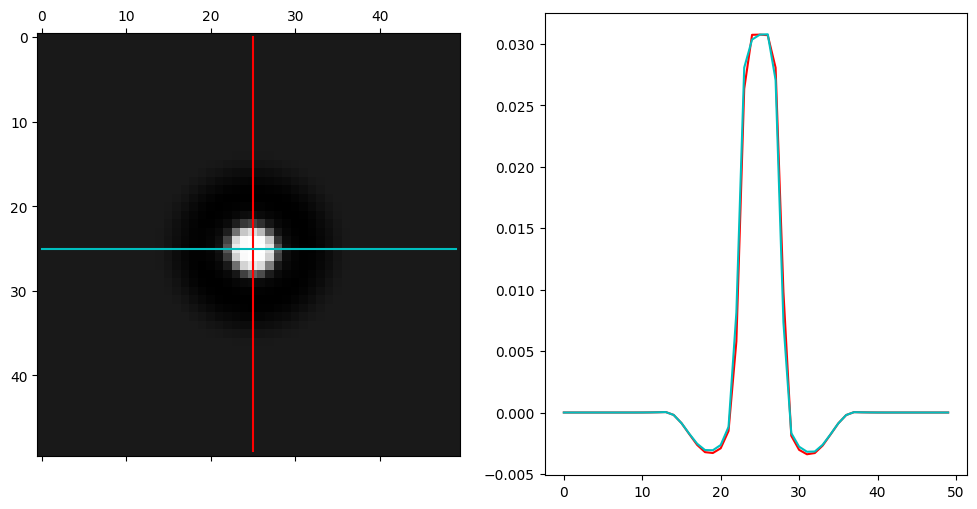

In [11]:
# Prepare the probe kernel

alpha_pr = 6 #manual modification of radius
# qx0_pr = 128
# qy0_pr = 128

probe.get_kernel(
    mode='sigmoid',
    origin=(qx0_pr,qy0_pr),
    radii=(alpha_pr,2*alpha_pr)
)

py4DSTEM.visualize.show_kernel(
    probe.kernel,
    R = 25,
    L = 25,
    W = 1
)

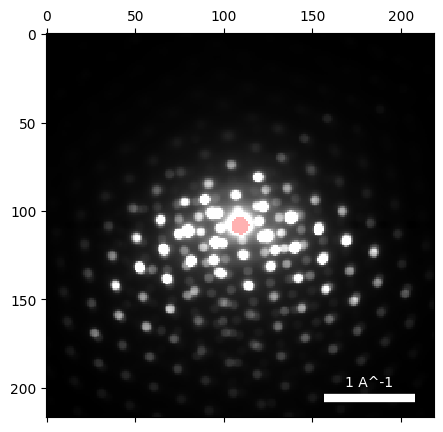

100%|███████████████████████████████████████████████████████████████████████████| 7134/7134 [00:00<00:00, 13685.52it/s]


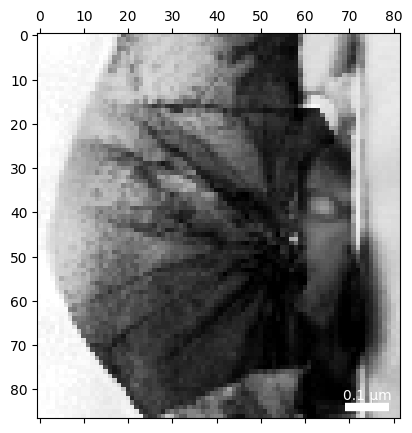

In [12]:
#Crop data to remove last two pixels and the y offset that contains DP without reflections
OffsetY = 0
data4D = data4D.crop_R([OffsetY, data4D.data.shape[0], 0, data4D.data.shape[1]]) #Ry_min,Ry_max,Rx_min,Rx_max - X=horizontal, Y=vertical
# BF Imaging
center = (qx0_pr,qy0_pr)
radius = 5
# overlay selected detector position over mean dp
data4D.position_detector(
    mode = 'circle',
    geometry = (
        center,
        radius
    )
)
data4D.get_virtual_image(
    mode = 'circle',
    geometry = (center,radius),
    name = 'bright_field',       # the output will be stored in `datacube`'s tree with this name
)
# show
py4DSTEM.visualize.show( data4D.tree('bright_field') )

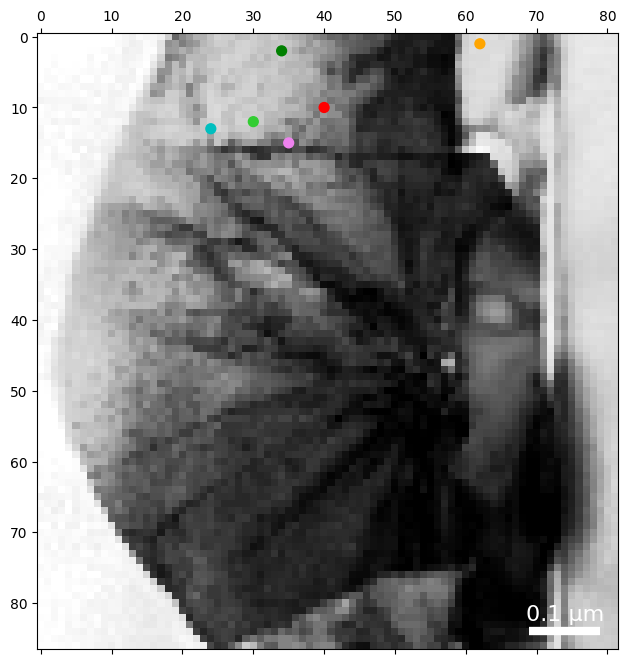

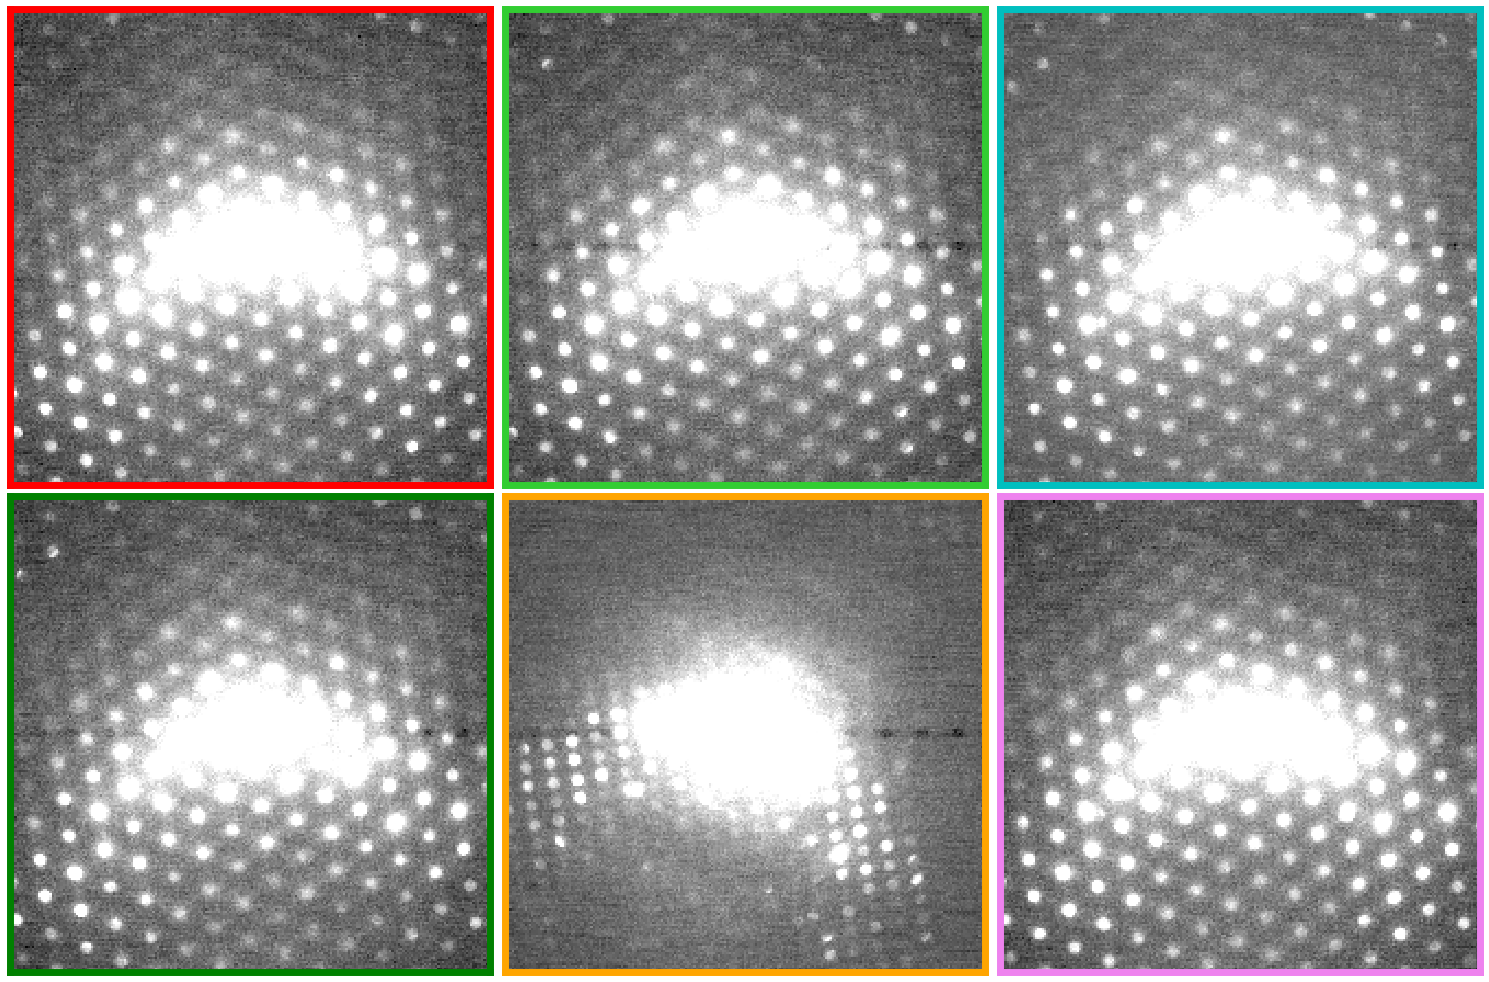

In [14]:
# Select a few sample patterns for parameter tuning

# set scan positions
rxs = 10, 12, 13, 2, 1, 15
rys = 40, 30, 24, 34, 62, 35

colors=['r','limegreen','c','g','orange', 'violet']

# show the selected real space positions
py4DSTEM.visualize.show_points(
    data4D.tree('bright_field'),
    x=rxs,
    y=rys,
    pointcolor=colors,
    figsize=(8,8)
)

# show the selected diffraction patterns
py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:data4D[rxs[i],rys[i],:,:],
    H=2,W=3,
    axsize=(5,5),
    intensity_range='absolute',
    vmin=10,
    vmax=5000,
    scaling='power',
    power=0.5,
    get_bordercolor = lambda i:colors[i],
)

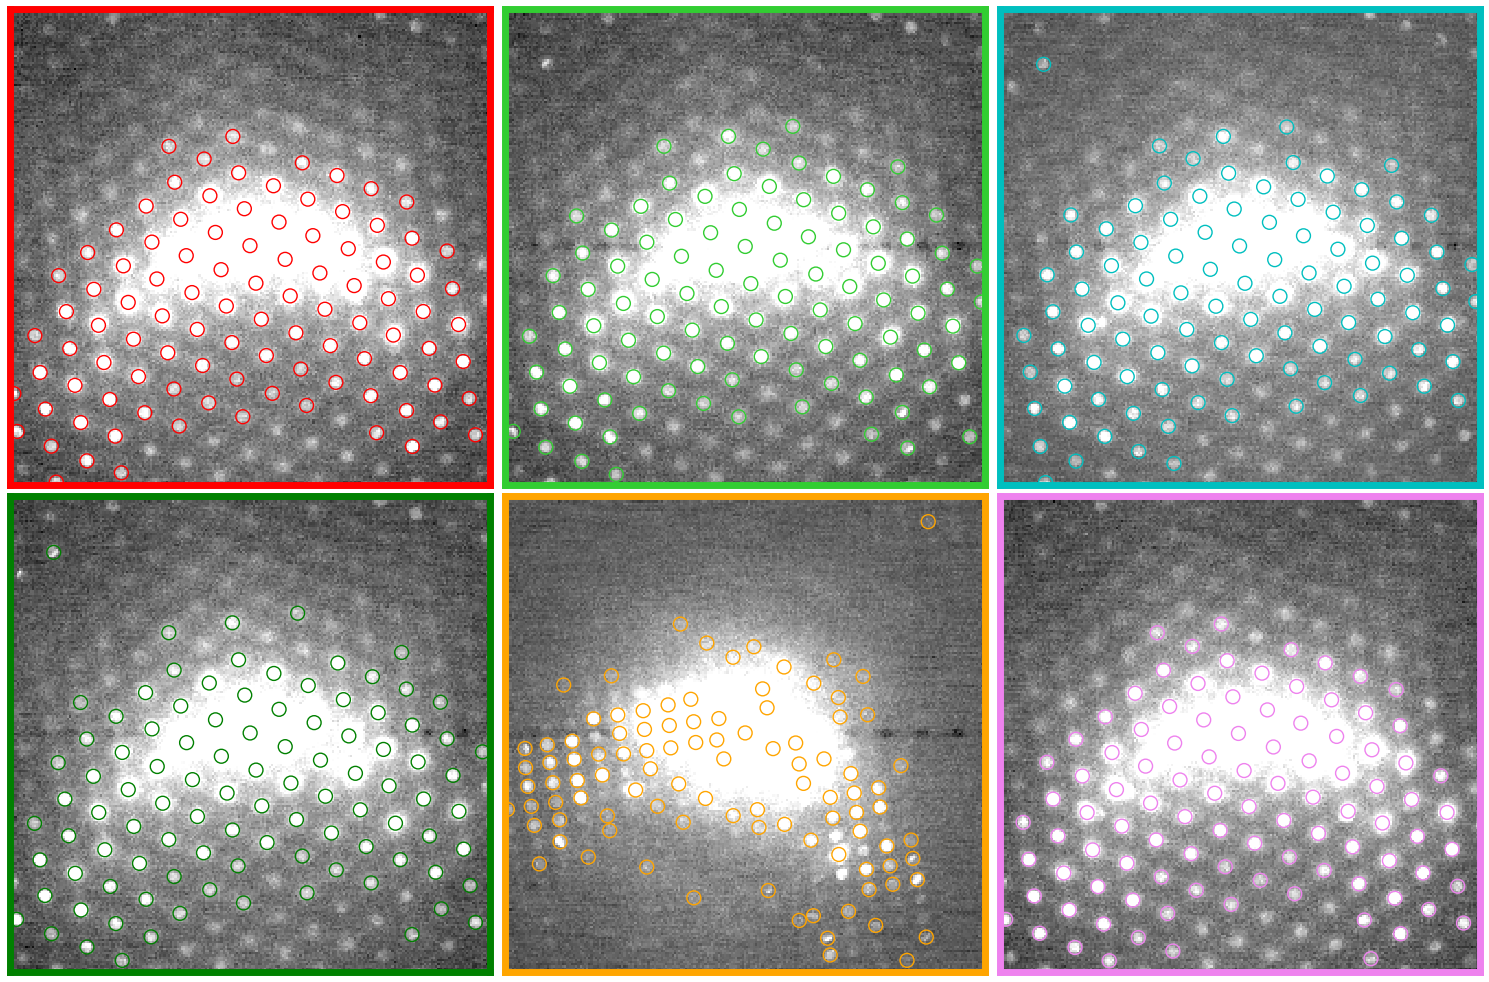

In [20]:
# Choose disk detection parameters and test them in a few patterns

# set parameters
detect_params = {
    'minAbsoluteIntensity': 20,   # intensity threshold
    'minRelativeIntensity': 0,   # int. thresh. relative to brightest disk in each pattern
    'minPeakSpacing': 5,         # if two peaks are closer than this (in pixels), remove the dimmer peak
    'edgeBoundary': 0,           # remove peaks within this distance of the edge of the diffraction pattern
    'sigma': 1,                  # gaussian blur size to apply to cross correlation before finding maxima
    'maxNumPeaks': 100,          # maximum number of peaks to return, in order of intensity
    'subpixel' : 'poly',         # subpixel resolution method
    'corrPower': 1,            # if <1.0, performs a hybrid cross/phase correlation. More sensitive to edges and to noise
#     'CUDA': True,              # if a GPU is configured and cuda dependencies are installed, speeds up calculation 
}

# Find disks for selected patterns
disks_selected = data4D.find_Bragg_disks(
    data = (rxs, rys),
    template = probe.kernel,
    **detect_params,
)

py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:data4D[rxs[i],rys[i],:,:],
    H=2, 
    W=3,
    axsize=(5,5),
    intensity_range='absolute',
    vmin=10,
    vmax=5000,
    scaling='power',
    power=0.5,
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 100,
)

In [21]:
# Compute Bragg reflection positions for all diffraction patterns

braggpeaks = data4D.find_Bragg_disks(
    template = probe.kernel,
    **detect_params,
)

Finding Bragg Disks: 100%|████████████████████████████████████████████████████████| 7.13k/7.13k [01:22<00:00, 86.3DP/s]


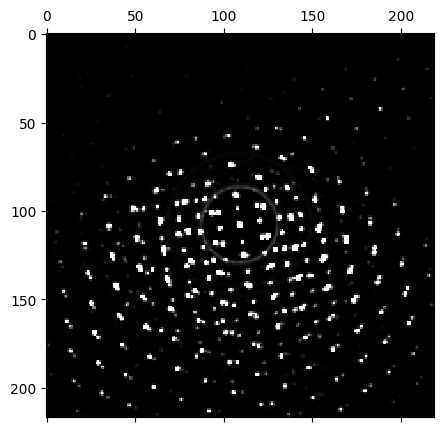

In [22]:
# Compute Bragg Vector Map (BVM)

bvm = braggpeaks.histogram( mode='raw' )
py4DSTEM.visualize.show(bvm)

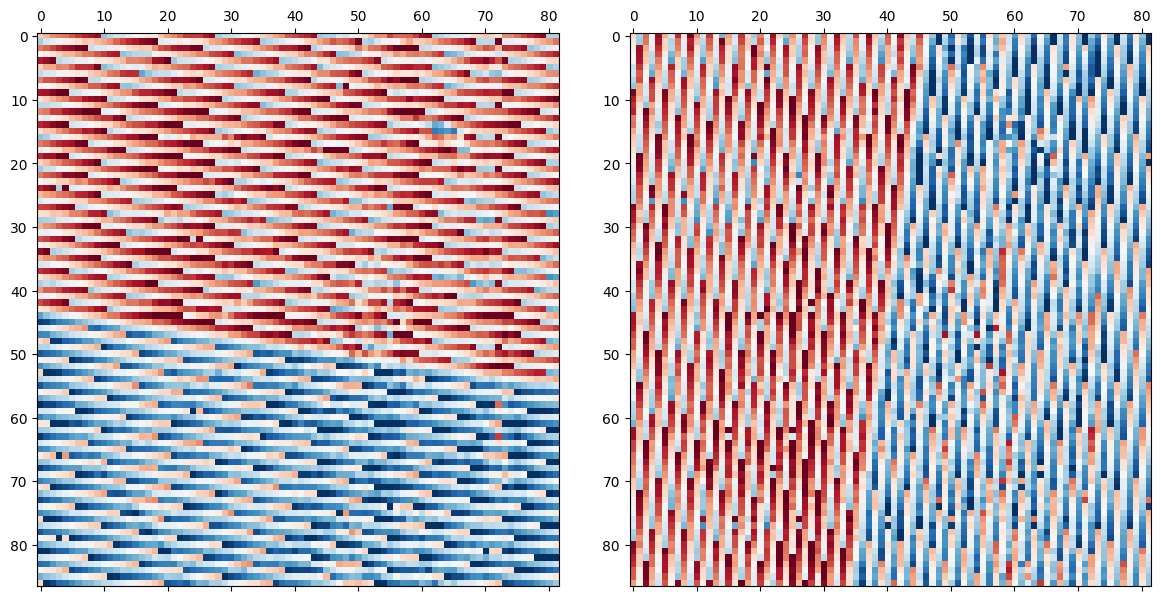

In [23]:
# Measure the origin
qx0_meas,qy0_meas,mask_meas = braggpeaks.measure_origin(center_guess=[qx0_pr,qy0_pr], )

py4DSTEM.visualize.show(
    [qx0_meas,qy0_meas],
    cmap = 'RdBu',
    mask = mask_meas
)

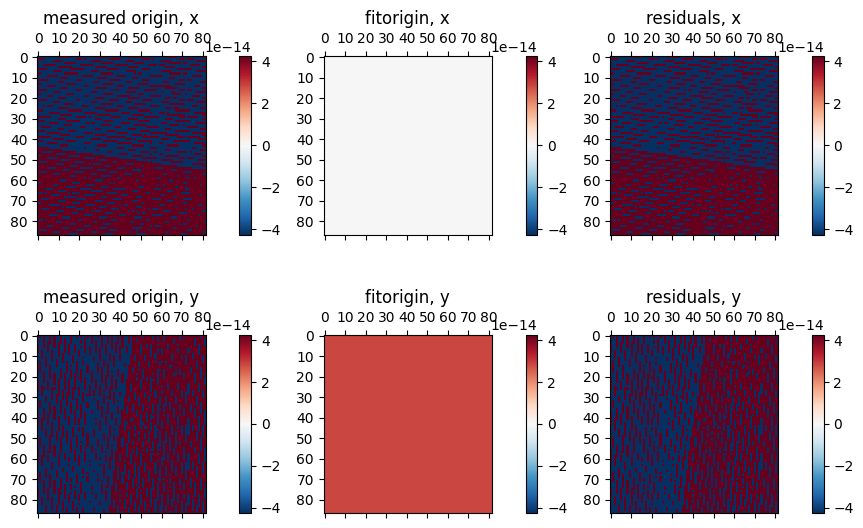

In [24]:
# Fit a plane to the origins
qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = braggpeaks.fit_origin(fitfunction="constant") #change it to plane or constant if necessary 

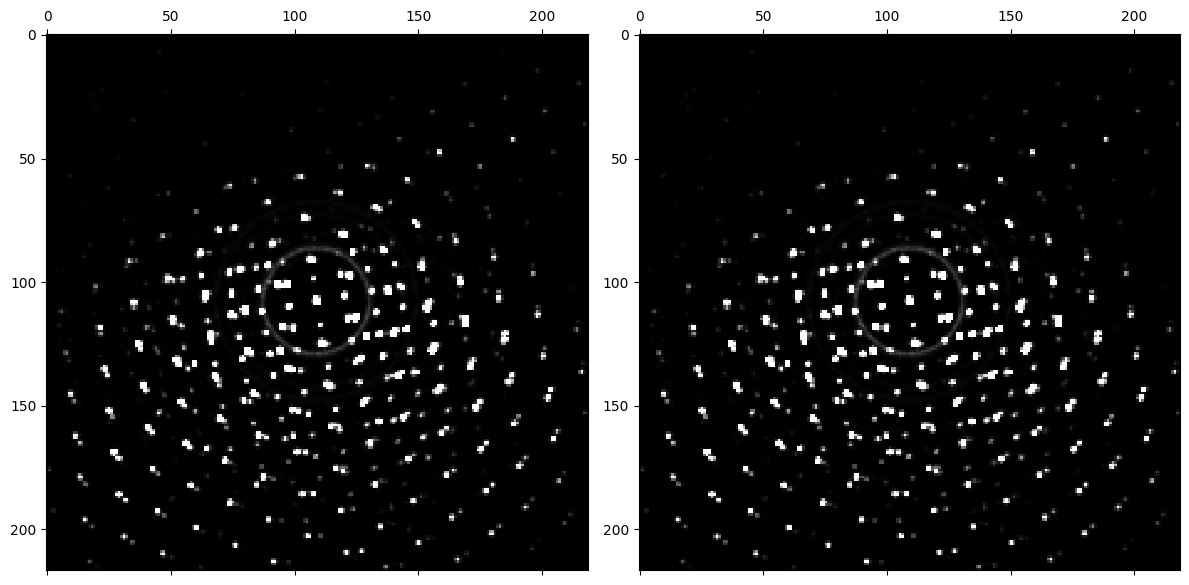

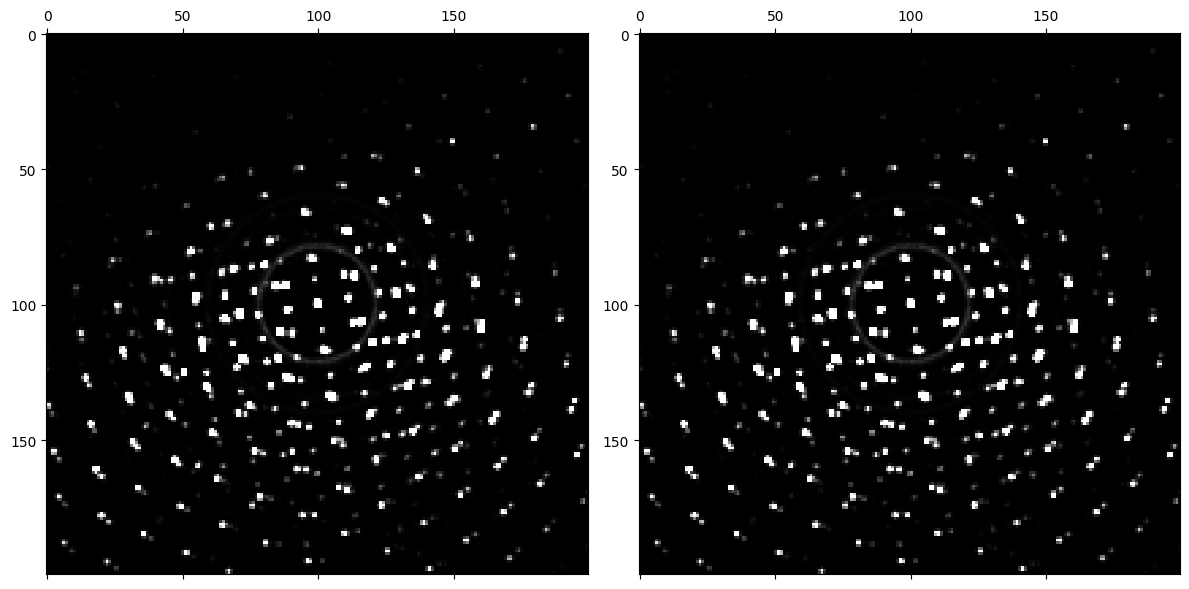

In [25]:
# Compare this to the uncalibrated Bragg vector map (BVM) - much better!

# compute raw vs. centered
bvm_r = braggpeaks.histogram( mode='raw')
bvm_c = braggpeaks.histogram( mode='cal' )

# show
py4DSTEM.visualize.show( [bvm_r, bvm_c])

# show, zooming in on origin
L = 100
x,y = bvm_c.origin
x0,xf = np.round([x-L,x+L]).astype(int)
y0,yf = np.round([y-L,y+L]).astype(int)

py4DSTEM.visualize.show(
    [
    bvm_r[x0:xf,y0:yf],
    bvm_c[x0:xf,y0:yf]
    ],
)

In [26]:
# Set the rotation

braggpeaks.calibration.set_QR_rotation_degrees( -8.4 ) # -11.1 for 800C
braggpeaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:          0.019510017335414888
             R_pixel_size:          0.00998444
             Q_pixel_units:         A^-1
             R_pixel_units:         µm
             QR_flip:               False
             probe_semiangle:       2.717116668297474
             qx0_mean:              107.70802579519659
             qy0_mean:              108.828868633153
             qx0_meas:              2D-array
             qy0_meas:              2D-array
             origin_meas_mask:      2D-array
             qx0:                   2D-array
             qx0_shift:             2D-array
             qy0:                   2D-array
             qy0_shift:             2D-array
             QR_rotation:           -0.1466076571675237
             QR_rotation_degrees:   -8.4
)

In [27]:
strainmap = py4DSTEM.StrainMap(braggvectors=braggpeaks)

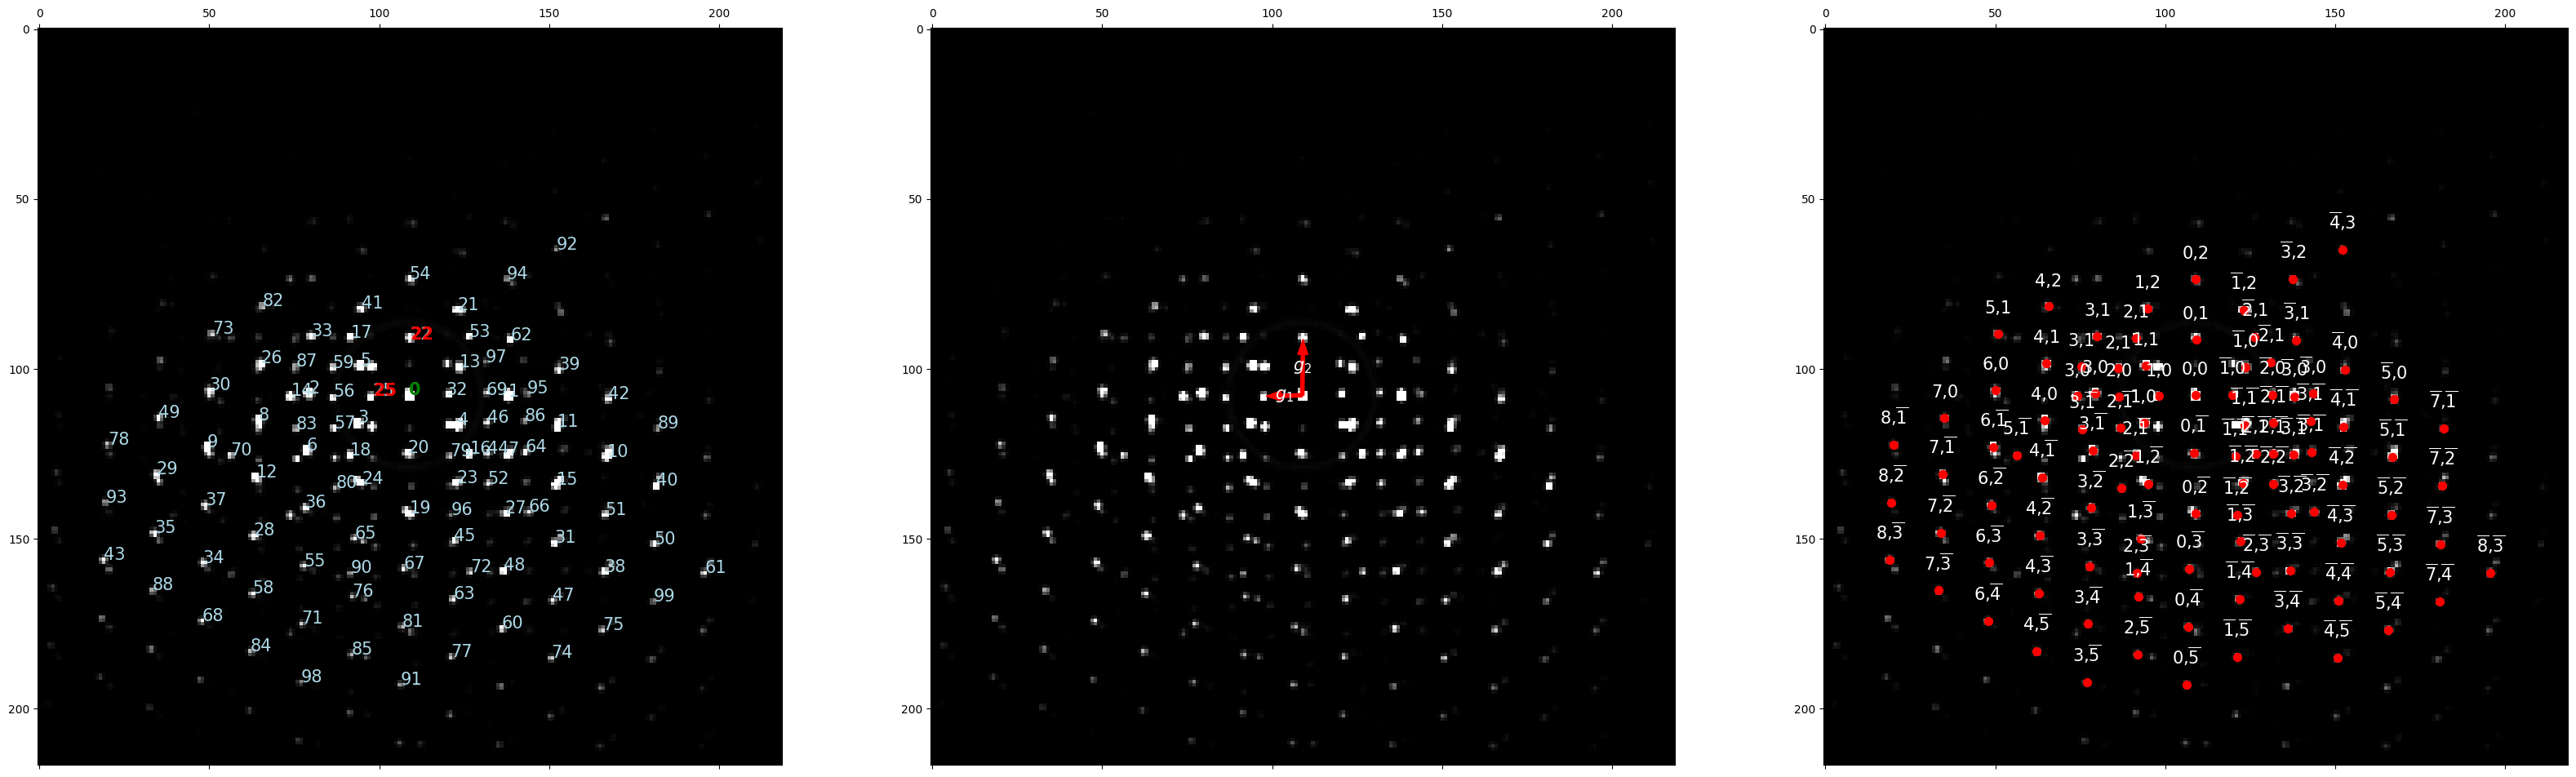

In [28]:
#The basis vectors are selected automatically
strainmap.choose_basis_vectors(
    minSpacing=5,
    minAbsoluteIntensity=1e4,
    maxNumPeaks=100,
    edgeBoundary=1,
    figsize = (40,30),
    vis_params = {
        'vmin' : 0,
        'vmax' : 0.995
    }
)

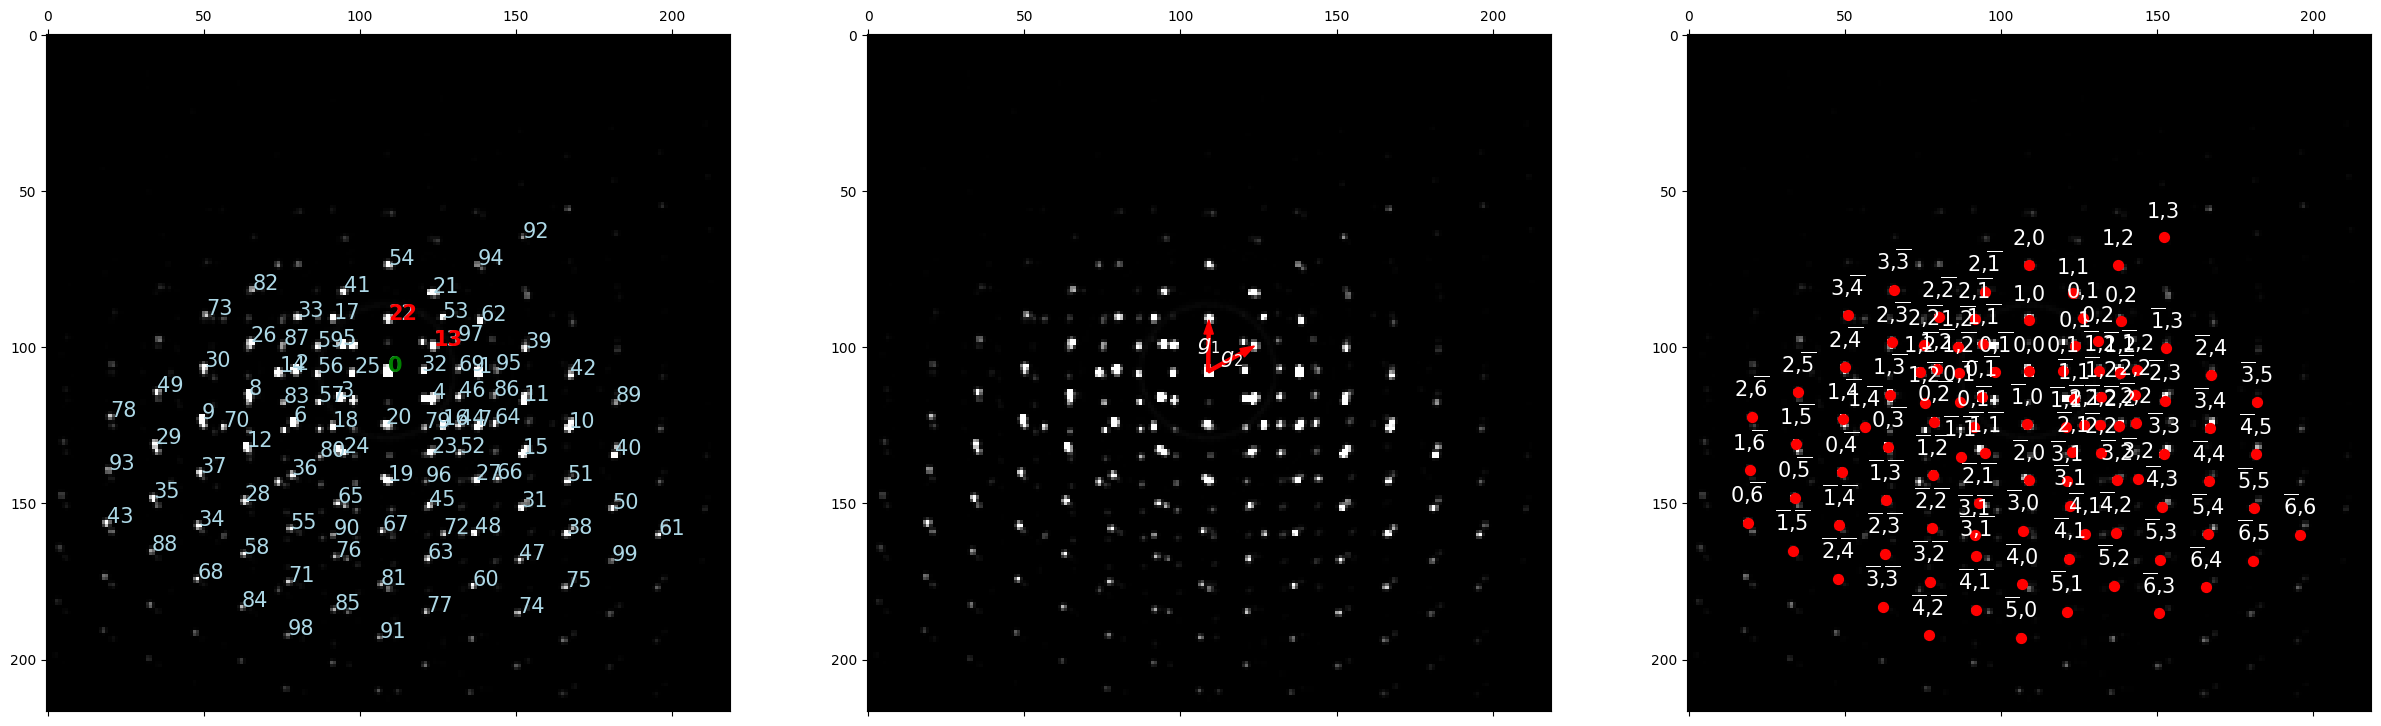

In [29]:
#if you want to manually select the reference basis vectors
strainmap.choose_basis_vectors(
    index_origin=0,
    index_g1=22,
    index_g2=13,
    minSpacing=5,
    minAbsoluteIntensity=1e4,
    maxNumPeaks=100,
    vis_params = {
        'vmin' : 0,
        'vmax' : 0.995
    },
    figsize = (30,20)
)

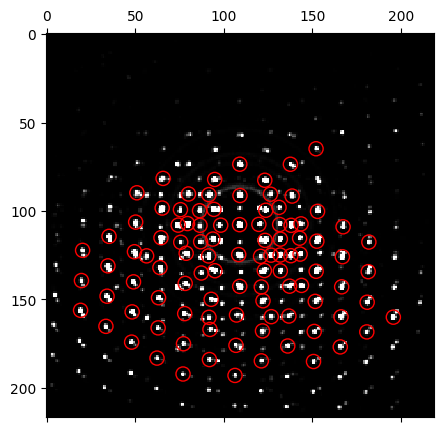

In [31]:
strainmap.set_max_peak_spacing(
    max_peak_spacing = 4
)

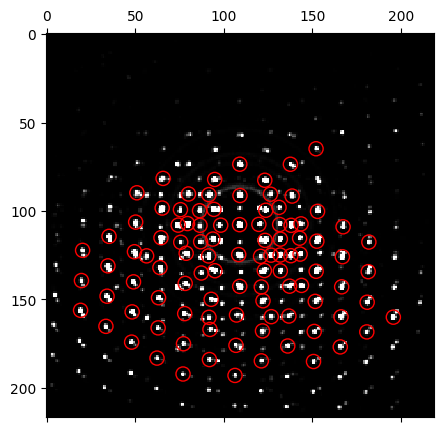

Indexing Bragg scattering: 100%|███████████████████████████████████████████████████| 7.13k/7.13k [00:16<00:00, 438DP/s]
Fitting lattice vectors: 100%|███████████████████████████████████████████████████| 7.13k/7.13k [00:02<00:00, 2.60kDP/s]


In [32]:
strainmap.fit_basis_vectors(
     max_peak_spacing = 4
)

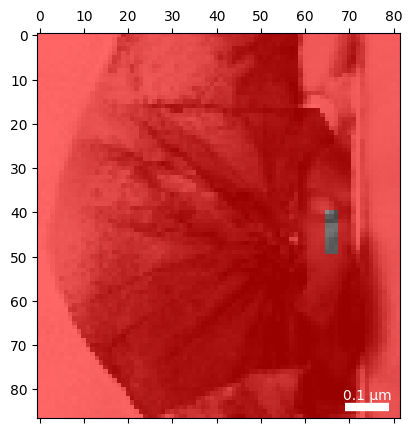

In [42]:
#Strain selecting the reference region

ROI = np.zeros(braggpeaks.Rshape, dtype=bool)
ROI[40:50, 65:68] = True

py4DSTEM.visualize.show(
    data4D.tree('bright_field'),
    mask = ROI,
    mask_color='r',
    mask_alpha=0.4
)

Calculating strain: 100%|████████████████████████████████████████████████████████| 7.13k/7.13k [00:02<00:00, 3.43kDP/s]


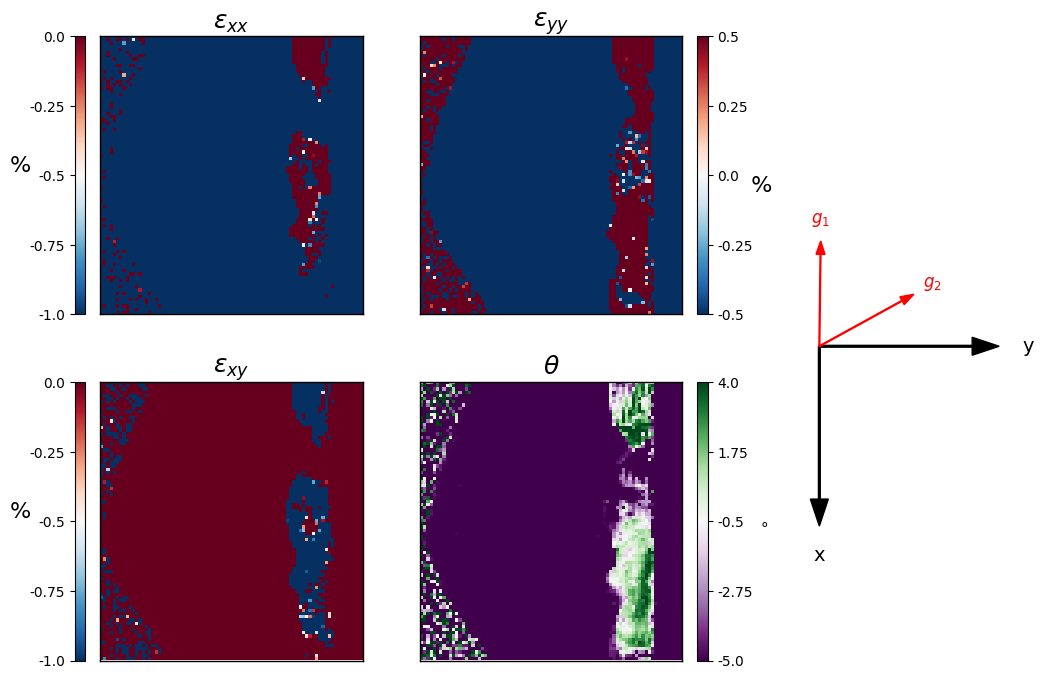

In [45]:
# Calculate strain from a region
strainmap.get_strain(
    gvects = ROI,
    coordinate_rotation = 0,
    vrange_exx = [-1, 0],
    vrange_eyy=[-0.5, 0.5],
    vrange_exy = [-1,0],
    vrange_theta=[-5, 4],
    layout="square",
)

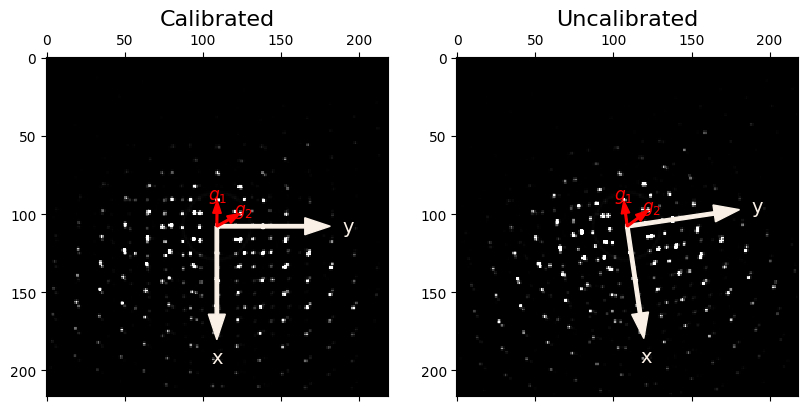

In [38]:
strainmap.show_reference_directions(
    visp_cal={
        'scaling' : 'none',
        'vmax' : 0.995
    },
    visp_uncal={
        'scaling' : 'none',
        'vmax' : 0.995
    },
    camera_length = 1.5,
)

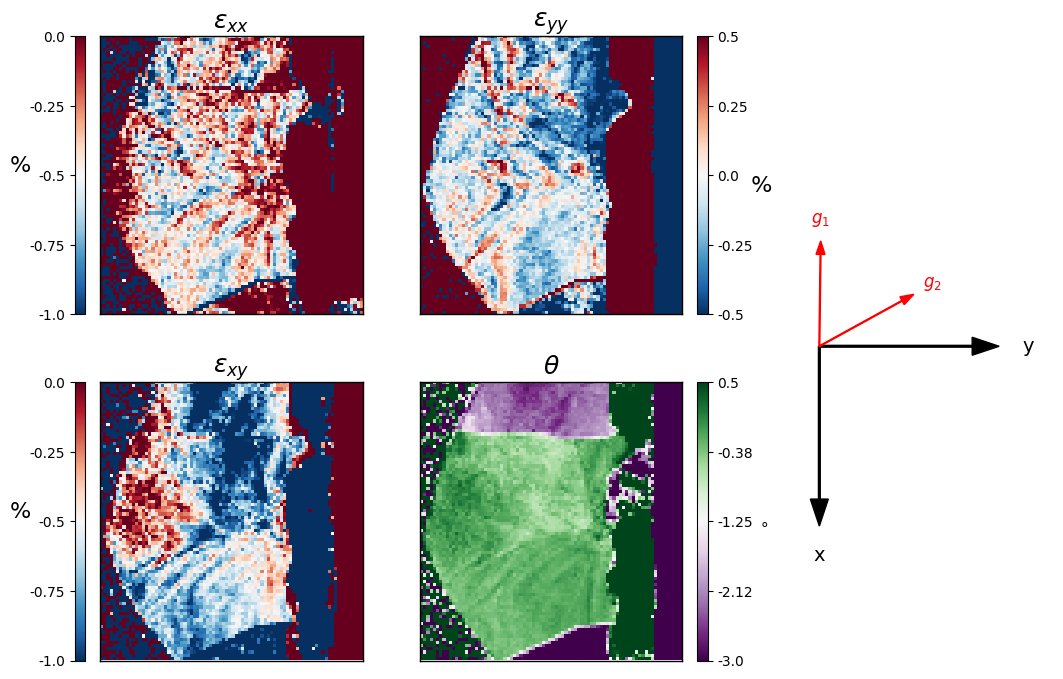

In [39]:
#Show and store figure of strain maps
[StrainFigure,ax]= strainmap.show_strain(
    vrange_exx = [-1, 0],
    vrange_eyy=[-0.5, 0.5],
    vrange_exy = [-1,0],
    vrange_theta=[-3, 0.5],
    show_gvects=True,
    layout='square',
    returnfig=True,
)
StrainFigure.savefig(filenameData+'_Yoffset_'+str(OffsetY)+'_Ysize_'+str(data4D.data.shape[0])+
                     '_StrainMaps.png',bbox_inches='tight')

In [40]:
from tifffile import imwrite
EXX = strainmap.data[0]*100 # in %
EYY = strainmap.data[1]*100 # in %
EXY = strainmap.data[2]*100 # in %
StrainRot = strainmap.data[3]*(180.0 / np.pi) # in degrees
imwrite(filenameData+'_Yoffset_'+str(OffsetY)+'_Ysize_'+str(data4D.data.shape[0])
        +'_strain_raw_exx.tiff',EXX.astype(np.float32))
imwrite(filenameData+'_Yoffset_'+str(OffsetY)+'_Ysize_'+str(data4D.data.shape[0])
        +'_strain_raw_eyy.tiff',EYY.astype(np.float32))
imwrite(filenameData+'_Yoffset_'+str(OffsetY)+'_Ysize_'+str(data4D.data.shape[0])
        +'_strain_raw_exy.tiff',EXY.astype(np.float32))
imwrite(filenameData+'_Yoffset_'+str(OffsetY)+'_Ysize_'+str(data4D.data.shape[0])
        +'_strain_raw_rot.tiff',StrainRot.astype(np.float32))